<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

**Описание проекта:**

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**План работы**:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

In [14]:
# Импорт библиотек
from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor

import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

In [15]:
# Откроем файл
df = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0]) # сразу же зададим столбец с дататой как индекс
df.sort_index(inplace=True)
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Нам предоставленны данные за период с начала марта по конец августа 2018 года, с типами данных все впорядке, целевым признаком является num_orders - число заказов. Нужно выполнить ресемплирование по 1 часу.

In [17]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

Проанализируем целевой признак, а после посмотрим графики сезонности и трендов.

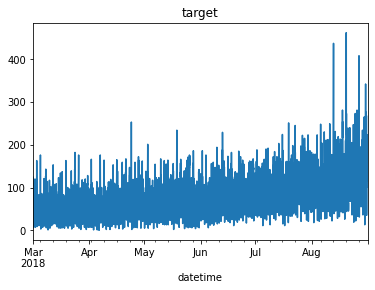

In [19]:
# Построим рафик для целевого признака
df['num_orders'].plot(title='target');

Видно, что в августе заказов было гораздо больше, возможно часто шли дожди, посмотрим сезонность и тренды.

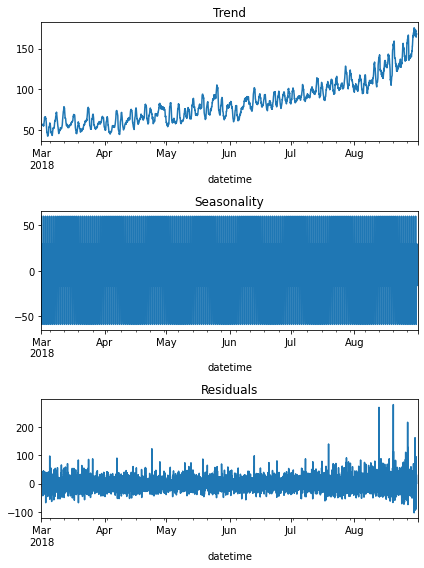

In [20]:
decomposed = seasonal_decompose(df) 

plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) # < напишите код здесь >
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) # < напишите код здесь >
plt.title('Residuals')
plt.tight_layout()

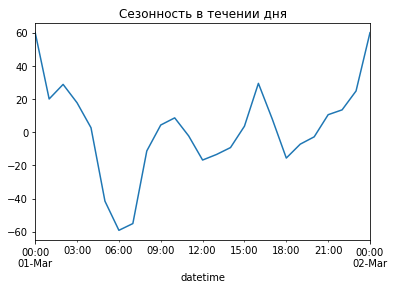

In [21]:
# Рассмотрим сезонность в течении 1 дня
decomposed = seasonal_decompose(df)
decomposed.seasonal['2018-03-01 00': '2018-03-02 00'].plot(ax=plt.gca(), title='Сезонность в течении дня');

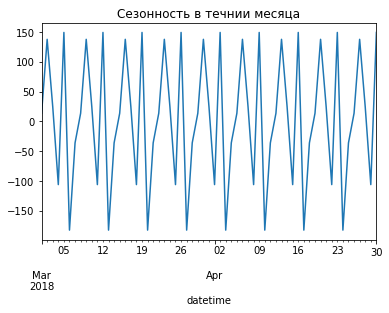

In [22]:
# Попробуем проанализировать сезонность сделав декомпозицию по дню и посмотрев данные за 1 месяц
df_day = df.resample('1D').sum()
decomposed = seasonal_decompose(df_day)
decomposed.seasonal['2018-03': '2018-04'].plot(ax=plt.gca(), title='Сезонность в течнии месяца');

тренд увеличивается с приближением к августу; сезонность распознать удалось лишь в течении дня - пик вызова такси приходится на 12 часов ночи, после чего идет спад и минимальное количество в 6 утра, далее идет рост(с 6 до 10, с 12 до 16 и с 18 до 00 ) с небольшими спадами(с 10 до 12, с 16 до 18); отстатки увеличиваются так же ближе к августу.

<AxesSubplot:xlabel='datetime'>

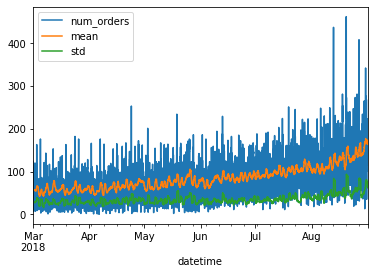

In [23]:
# Воспользуемся стационарными рядами для большего понимания
df['mean'] = df['num_orders'].rolling(24).mean()
df['std'] = df['num_orders'].rolling(24).std()
df.plot() 

Наш датафрейм не является стационарным, его среднее не стоит на месте.

## Обучение

In [24]:
# Создадим функцию для добавления каленарных признаков, отстающих значений и скользящего среднего
def make_features(data, max_lag, rolling_mean_size): # функция принимает датафрейм, максимальное число отстающих значений
# и размер окна для скользящего среднего
  
    data['dayofweek'] = data.index.dayofweek
    data['hours'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [25]:
make_features(df, 168, 168) # остановимся пока на этих значениях

# Разделим датафрейм на выборки и создадим features и target 
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders', 'std', 'mean'], axis=1)
features_test= test.drop(['num_orders', 'std', 'mean'], axis=1)

target_train = train['num_orders']
target_test = test['num_orders']

print(features_train.shape)
print(features_test.shape)

(3806, 171)
(442, 171)


Рассмотрим модели SGDRegressor, CatBoost и случайный лес

In [33]:
# SGDRegressor

scaler = StandardScaler()
scaler.fit(features_train)
features_scaler = scaler.transform(features_train)

# Выбираем параметры
linear_params = {
'eta0': [0.01]
}
# Разделяем на выборки 
tscv = TimeSeriesSplit(n_splits=5)

# Создаем модель
linear = SGDRegressor()

# Создаем способ подбора
grid_linear = GridSearchCV(linear, linear_params, cv=tscv, 
                           scoring='neg_root_mean_squared_error')

# Обучаем
grid_linear.fit(features_scaler, target_train)

print('Лучшие параметры:', grid_linear.best_params_)
print('Лучший счет:', -grid_linear.best_score_)

Лучшие параметры: {'eta0': 0.01}
Лучшый счет: 24.590184322023372


Хороший результат. Посмотрим далее.

In [30]:
%%time
# CatBoost
cat_params = {
'n_estimators': range(100, 300, 100),
'learning_rate': [0.05, 0.1, 0.3],
'verbose': [False],
'grow_policy': ['Lossguide'],
'num_leaves': [5, 10, 20],
'depth': range(1, 5, 2),
}

tscv = TimeSeriesSplit(n_splits=5)

cat = CatBoostRegressor()

grid_cat = GridSearchCV(cat, cat_params, cv=tscv, scoring='neg_root_mean_squared_error')

grid_cat.fit(features_train, target_train)

print('Лучшие параметры:', grid_cat.best_params_)
print('Лучший счет:', -grid_cat.best_score_)

Лучшие параметры: {'depth': 3, 'grow_policy': 'Lossguide', 'learning_rate': 0.05, 'n_estimators': 200, 'num_leaves': 10, 'verbose': False}
Лучший счет: 22.46435978524629
CPU times: user 3min 26s, sys: 1.78 s, total: 3min 28s
Wall time: 5min 36s


Результаты еще лучше, проверим так же случайный лес.

In [34]:
%%time
# Случайный лес
rfc = RandomForestRegressor(random_state=12345)

parametrs = { 'n_estimators': range (30, 61, 10),
              'max_depth': range (1,5, 2)}

grid_rfc = GridSearchCV(rfc, parametrs, cv=tscv, scoring='neg_root_mean_squared_error')
grid_rfc.fit(features_train, target_train)

print('Лучшие параметры:', grid_rfc.best_params_, '\n')
print('Лучший счет:', -grid_rfc.best_score_, '\n')

Лучшие параметры: {'max_depth': 3, 'n_estimators': 50} 

Лучшый счет: 25.04077975920469 

CPU times: user 42.3 s, sys: 47.2 ms, total: 42.3 s
Wall time: 42.4 s


Результаты хуже, чем у предшественников.

## Тестирование

Проведем тестирование на модели CatBoost т.к. она показала лучшие результаты.

In [31]:
pred = grid_cat.best_estimator_.predict(features_test)
print('RMSE:',  mean_squared_error(pred, target_test, squared=False))

RMSE: 36.56903957677199


Хороший результат

## Вывод

Был произведен осмотр данных, выделен целевой признак, выполнено ресемплирование по одному часу. в результаты исследований мы узнали, что тренд увеличивается с приближением к августу, сезонность распознать не удалось, отстатки увеличиваются так же ближе к августу. Датафрейм не является стационарным, его среднее не стоит на месте. Были обучены модели SGD, CatBoost, случайный лес. Лучшие результаты на тестовой выборки показала модель CatBoost с параметрами 'depth': 3, 'grow_policy': 'Lossguide', 'learning_rate': 0.05, 'n_estimators': 200, 'num_leaves': 10; значение метрики - RMSE: 36.569, задача выполнена, метрика ниже 48.